In [3]:
%matplotlib inline
import os
import pickle
import argparse
import numpy as np
from itertools import cycle
from collections import defaultdict
from functools import partial
from typing import List, Dict, Tuple

from qanta.guesser.abstract import AbstractGuesser
from qanta.datasets.quiz_bowl import QuestionDatabase
from qanta.util import constants as c
from qanta.buzzer import constants as bc
from qanta import logging
from qanta.buzzer.util import GUESSERS, load_protobowl
from qanta.reporting.report_generator import ReportGenerator
from qanta.util.multiprocess import _multiprocess

/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/airsplay/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
from qanta.reporting.new_performance import get_his_stats, get_protobowl, _get_top_guesses

/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [10]:
all_questions = QuestionDatabase().all_questions()
answers = {k: v.page for k, v in all_questions.items()}
question_texts = {k: v.text for k, v in all_questions.items()}
protobowl_ids = {k: all_questions[k].protobowl 
    for k in all_questions if all_questions[k].protobowl != ''}
protobowl_df, user_count = load_protobowl()

guesses_df_folds = dict()
top_guesses_folds = dict()
for fold in c.BUZZER_GENERATION_FOLDS:
    guesses_df_folds[fold] = AbstractGuesser.load_guesses(
            bc.GUESSES_DIR, folds=[fold])
    questions = guesses_df_folds[fold].groupby('qnum')
    top_guesses_folds[fold] = _multiprocess(_get_top_guesses, questions, 
            info='Top guesses', multi=True)
    top_guesses_folds[fold] = {k: v for k, v in top_guesses_folds[fold]}

[Top guesses] (16) done: 7587/7587
[Top guesses] (16) done: 2089/2089
[Top guesses] (16) done: 1412/1412
[Top guesses] (16) done: 69/69


In [5]:
def plot(fold, model_name, protobowldf, save_dir=None):
    questions = guesses_df_folds[fold].groupby('qnum')

    buzzes_dir = bc.BUZZES_DIR.format(fold, model_name)
    with open(buzzes_dir, 'rb') as infile:
        buzzes = pickle.load(infile)
        
    inputs = [top_guesses_folds[fold], buzzes, answers, None, fold, save_dir]

    # get_his_stats(*inputs)
    p_inputs = [question_texts, protobowl_ids, protobowldf, questions] + inputs
    stats = get_protobowl(p_inputs)
    return stats

In [7]:
import importlib
from qanta.buzzer import util
importlib.reload(util)
protobowl_df, user_count = util.load_protobowl()

In [8]:
from collections import defaultdict
model_names = ['rnn_10', 'rnn_25', 'rnn_50', 'rnn_100', 'rnn_200']
user_answers_thresholds = [1,5,10,50,100,200,500,1000,2000]
new_stats = {k: [] for k in model_names}
for model_name in model_names:
    for threshold in user_answers_thresholds:
        print(model_name, threshold)
        pdf1 = protobowl_df[protobowl_df.user_answers > threshold]
        pstats = plot('buzzerdev', model_name, pdf1.groupby('qid'), save_dir='output/summary/new_performance/')
        new_stats[model_name].append(pstats)

rnn_10 1


/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


rnn_10 5
rnn_10 10
rnn_10 50
rnn_10 100
rnn_10 200
rnn_10 500
rnn_10 1000
rnn_10 2000
rnn_25 1
rnn_25 5
rnn_25 10
rnn_25 50
rnn_25 100
rnn_25 200
rnn_25 500
rnn_25 1000
rnn_25 2000
rnn_50 1
rnn_50 5
rnn_50 10
rnn_50 50
rnn_50 100
rnn_50 200
rnn_50 500
rnn_50 1000
rnn_50 2000
rnn_100 1
rnn_100 5
rnn_100 10
rnn_100 50
rnn_100 100
rnn_100 200
rnn_100 500
rnn_100 1000
rnn_100 2000
rnn_200 1
rnn_200 5
rnn_200 10
rnn_200 50
rnn_200 100
rnn_200 200
rnn_200 500
rnn_200 1000
rnn_200 2000


/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


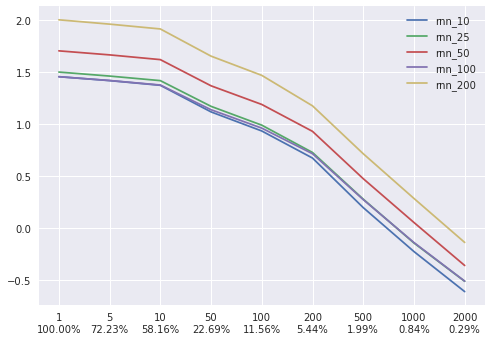

In [17]:
num_users = len(user_count)
def user_percentage(threshold):
    good_users = [k for k, v in user_count.items() if v >= threshold]
    return len(good_users) / num_users

from matplotlib import pyplot as plt
plt.clf()
for model_name in model_names:
    rewards = [x['reward'] for x in new_stats[model_name]]
    plt.plot(rewards, label=model_name)
xticks = ['{0}\n{1:.2f}%'.format(t, user_percentage(t)*100) for t in user_answers_thresholds]
plt.xticks(list(range(len(xticks))), xticks)
plt.legend()

/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


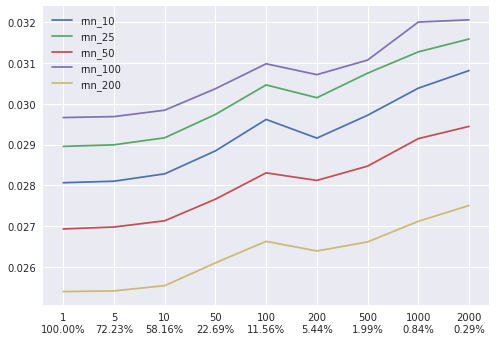

In [27]:
plt.clf()
for model_name in model_names:
    rewards = [x['rush_impossible'] for x in new_stats[model_name]]
    plt.plot(rewards, label=model_name)
xticks = ['{0}\n{1:.2f}%'.format(t, user_percentage(t)*100) for t in user_answers_thresholds]
plt.xticks(list(range(len(xticks))), xticks)
plt.legend()

In [20]:
from qanta.buzzer.interface import buzzer2vwexpo

expo_buzzes_dir = bc.BUZZES_DIR.format('expo', 'rnn_200')
with open(expo_buzzes_dir, 'rb') as infile:
    expo_buzzes = pickle.load(infile)
expo_guesses_df = AbstractGuesser.load_guesses(bc.GUESSES_DIR, folds=['expo'])
buzzer2vwexpo(expo_guesses_df, expo_buzzes, 'expo')

[buzzer2vwexpo] (16) done: 69/69
2017-05-26 05:40:25,983 - qanta.buzzer.interface - INFO - 

[buzzer2vwexpo] writing to files
2017-05-26 05:40:26,113 - qanta.buzzer.interface - INFO - buzz file written
2017-05-26 05:40:26,115 - qanta.buzzer.interface - INFO - final file written
2017-05-26 05:40:26,217 - qanta.buzzer.interface - INFO - vw_pred file written
2017-05-26 05:40:26,271 - qanta.buzzer.interface - INFO - vw_meta file written


In [28]:
from collections import defaultdict
model_names = ['rnn_1_200']
user_answers_thresholds = [1,5,10,50,100,200,500,1000,2000]
newnew_stats = {k: [] for k in model_names}
for model_name in model_names:
    for threshold in user_answers_thresholds:
        print(model_name, threshold)
        pdf1 = protobowl_df[protobowl_df.user_answers > threshold]
        pstats = plot('buzzerdev', model_name, pdf1.groupby('qid'), save_dir='output/summary/new_performance/')
        newnew_stats[model_name].append(pstats)

rnn_1_200 1


/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


rnn_1_200 5
rnn_1_200 10
rnn_1_200 50
rnn_1_200 100
rnn_1_200 200
rnn_1_200 500
rnn_1_200 1000
rnn_1_200 2000


/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


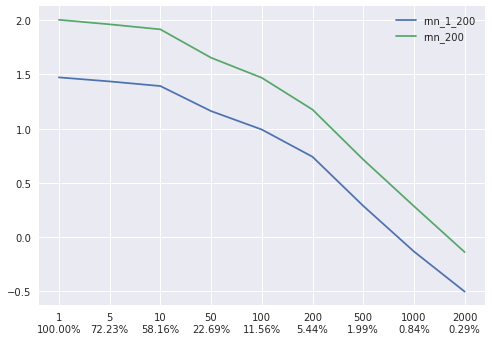

In [29]:
plt.clf()
plt.plot([x['reward'] for x in newnew_stats['rnn_1_200']], label='rnn_1_200')
plt.plot([x['reward'] for x in new_stats['rnn_200']], label='rnn_200')
xticks = ['{0}\n{1:.2f}%'.format(t, user_percentage(t)*100) for t in user_answers_thresholds]
plt.xticks(list(range(len(xticks))), xticks)
plt.legend()

In [1]:
new_stats['rnn_200'][0]

NameError: name 'new_stats' is not defined

In [7]:
protobowl_df, user_count = load_protobowl()
pstats = plot('buzzerdev', 'rnn_200', protobowl_df.groupby('qid'), save_dir='output/summary/new_performance/')

NameError: name 'guesses_df_folds' is not defined